In [1]:
import sys
sys.path.append('..')
import jax
from jax import vmap
import numpy as np
import matplotlib.pyplot as plt
from src.util import *
from src.plot import *
from src.stokes import *
from src.gp_shapes import *

I0000 00:00:1731456271.248508   92708 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


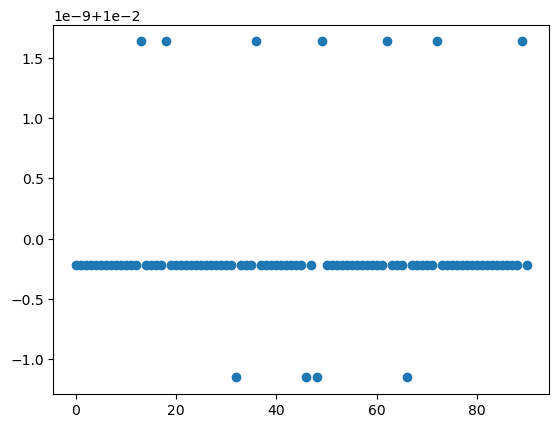

In [2]:
idx = 0

c_data = jnp.load(f"../data/data_{idx}.npy")[:100]
f_data = jnp.load(f"../data/f_data_{idx}.npy")[:100]

# Remove unphysical data
c_data, f_data = filter_unphysical(c_data, f_data)
norms = vmap(jnp.linalg.norm, 0)(f_data) / f_data.shape[1]
c_data = c_data[norms < 12]
f_data = f_data[norms < 12]

# Normalize the data
f_data = f_data / vmap(jnp.linalg.norm, 0)(f_data)[:, None, None]

dist_table, theta_table, gamma_table = get_align_table(c_data, c_data, Nref = 100)
theta_table = theta_table.squeeze()
plt.scatter(jnp.arange(len(f_data)), vmap(jnp.linalg.norm, 0)(f_data)/f_data.shape[1])

(100,) (21, 1)
(21, 91, 1)


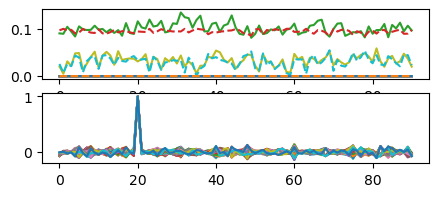

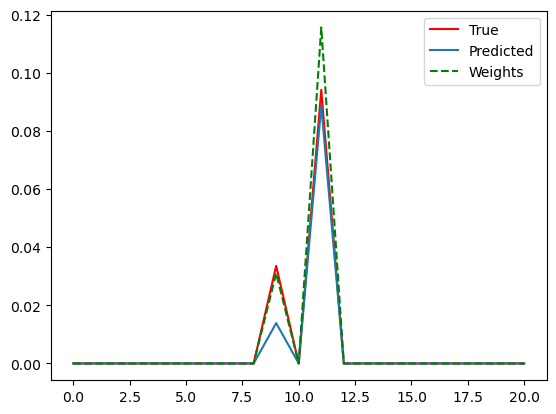

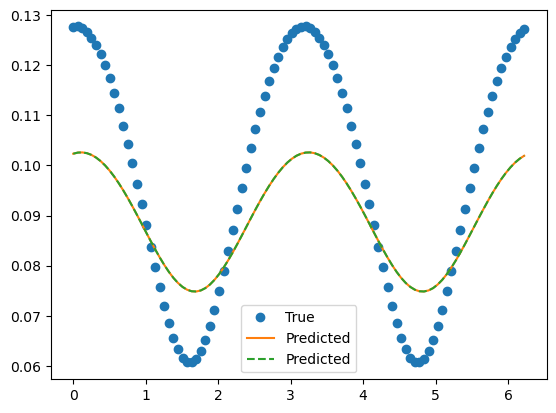

In [ ]:
def to_fourier(f_data, K):
    f_data_compl = f_data[:, 0] + 1j * f_data[:, 1]
    t = jnp.linspace(0, 2*jnp.pi, f_data.shape[0]+1)[:-1]
    fc_data = fit_fourier(t, f_data_compl, K)
    return fc_data

def precompute_gp_weights(kernel, dist_table, theta_table, gamma_table, fc_data):
    K = (fc_data.shape[1] - 1) // 2
    ks = jnp.linspace(-K, K, 2*K+1)
    
    dist_table = kernel(dist_table)
    Kmat = lambda k: jnp.exp(1j*k*gamma_table-1j*theta_table) * dist_table
    
    weights = vmap(lambda k,v: jnp.linalg.solve(Kmat(k), v), (0, 1))(ks, fc_data)
    return weights

def eval_gp(c, c_data, weights, kernel):
    K = (weights.shape[0] - 1)// 2 
    ks = jnp.linspace(-K, K, 2*K+1)
    
    dists, thetas, gammas = vmap(lambda c2: align_fourier_info(c, c2), (0))(c_data)
    dists = kernel(dists)

    Kmat = lambda k: jnp.exp(1j*k*gammas-1j*thetas) * dists
    #evals = vmap(lambda k, w: jnp.sum(Kmat(k) * w), (0, 0))(ks, weights)
    #print(weights.shape, vmap(Kmat)(ks).shape)
    evals = jnp.einsum("kn, kni -> ki", vmap(Kmat)(ks), weights)
    return evals, vmap(lambda k: Kmat(k), 0)(ks)


K = 10
sigma = 0.1
fc_data = vmap(to_fourier, (0, None))(f_data, K)
kernel = lambda r: jnp.exp(-r/sigma)

weights = precompute_gp_weights(kernel, dist_table, theta_table, gamma_table, fc_data)

i_test = 20
c = c_data[i_test]

fc_pred, rbfs = eval_gp(c, c_data, weights, kernel)
fc_pred2, _ = eval_gp(c*1j, c_data, weights, kernel)

fc = fc_data[i_test]
fc_pred2 = fc_pred2 * (-1j)


t = jnp.linspace(0, 2*jnp.pi, 101)[:-1]
print(t.shape, fc_pred.shape)
f = fourier_eval(t, fc)
f_pred = fourier_eval(t, fc_pred)
f_pred2 = fourier_eval(t, fc_pred2)

plt.figure(figsize=(5,2))
#print(fc_data.shape, weights.shape)
plt.subplot(211)
for i in range(fc_data.shape[1]):
    plt.plot(jnp.abs(weights[i, :]))
    plt.plot(jnp.abs(fc_data[:, i]), '--')
plt.subplot(212)
for i in range(fc_data.shape[1]):
    plt.plot(rbfs[i].real)

plt.figure()
print(weights.shape)
plt.plot(jnp.abs(fc), 'red', label='True')
plt.plot(jnp.abs(fc_pred), label='Predicted')
plt.plot(jnp.abs(weights[:, i_test]), 'g--', label='Weights')
#plt.plot(rbfs[i_test])
plt.legend()

plt.figure()
plt.plot(t, jnp.abs(f), 'o', label='True')   
plt.plot(t, jnp.abs(f_pred), label='Predicted')
plt.plot(t, jnp.abs(f_pred2), label='Predicted', linestyle='--')
plt.legend()


In [4]:
theta = 0.3*np.pi
rho = 0.5

def stack(A):
    return jnp.vstack([jnp.hstack([A.real, -A.imag]), jnp.hstack([A.imag, A.real])])

A = jnp.array([[1., rho*jnp.exp(1j*theta)], [rho*jnp.exp(-1j*theta), 1.]])


print(stack(jnp.linalg.inv(A)) - jnp.linalg.inv(stack(A)))

[[ 0.0000000e+00 -2.9802322e-08  1.4901161e-08 -5.9604645e-08]
 [ 0.0000000e+00  1.1920929e-07  0.0000000e+00  1.6321472e-08]
 [ 1.2036063e-08  0.0000000e+00  0.0000000e+00  2.9802322e-08]
 [-5.9604645e-08  1.8404895e-09  2.9802322e-08 -1.1920929e-07]]


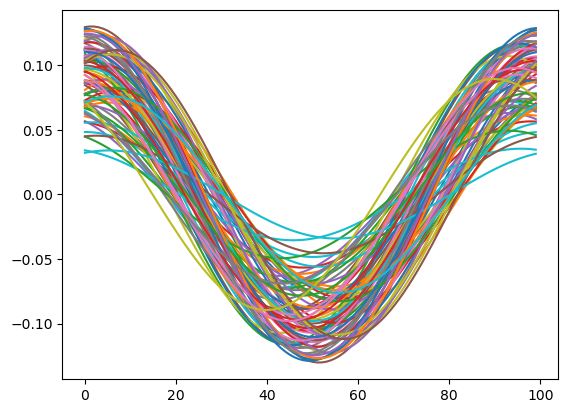

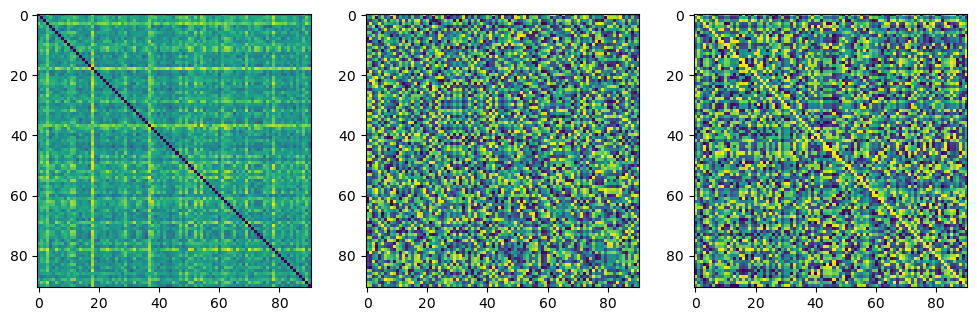

In [5]:

plt.figure()
for i in range(80):
    plt.plot(f_data[i, :, 0])

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(dist_table)
plt.subplot(132)
plt.imshow(theta_table)
plt.subplot(133)
plt.imshow(gamma_table)